In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import glob
import os

Error processing /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/invalid_matrices_log_merged.csv: unsupported operand type(s) for /: 'str' and 'str'


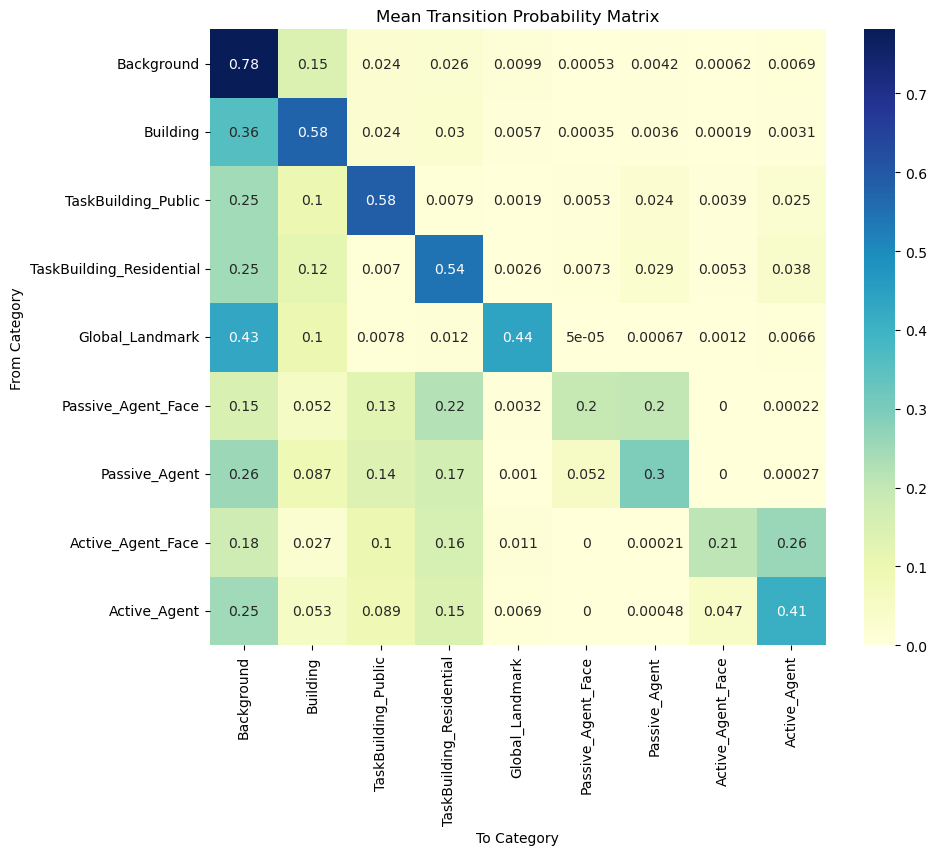

In [2]:
# Path where matrices are saved
save_matrix_path = "/Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/"

# Load all transition matrix CSV files in the directory
matrix_files = glob.glob(os.path.join(save_matrix_path, "*.csv"))

# Initialize a list to store each normalized matrix as a DataFrame
normalized_matrices = []

# Load each matrix, normalize, and append to the list
for file in matrix_files:
    try:
        # Load matrix and set the first column as the row index
        df = pd.read_csv(file, index_col=0)

        # Check if any row sums to zero (i.e., missing transitions)
        if (df.sum(axis=1) == 0).any():
            print(f"Warning: Matrix in {file} has rows that sum to zero, indicating missing transitions.")
        
        # Normalize each row to ensure rows sum to 1
        df = df.div(df.sum(axis=1), axis=0).fillna(0)
        normalized_matrices.append(df)
    
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Ensure all matrices have the same structure as the first matrix
reference_matrix = normalized_matrices[0]
for i, matrix in enumerate(normalized_matrices):
    normalized_matrices[i] = matrix.reindex_like(reference_matrix).fillna(0)

# Check consistency in matrix shapes
consistent_shape = all(matrix.shape == reference_matrix.shape for matrix in normalized_matrices)
if not consistent_shape:
    raise ValueError("Inconsistent matrix shapes detected after reindexing. Verify the input data.")

# Calculate the mean of all normalized matrices
mean_matrix = sum(normalized_matrices) / len(normalized_matrices)

# Plot the heatmap of the mean matrix
plt.figure(figsize=(10, 8))
sns.heatmap(mean_matrix, annot=True, cmap="YlGnBu", cbar=True, square=True,
            xticklabels=mean_matrix.columns, yticklabels=mean_matrix.index)
plt.title('Mean Transition Probability Matrix')
plt.xlabel('To Category')
plt.ylabel('From Category')
plt.show()


In [3]:
def load_matrix(file_path, reference_index=None):
    """
    Load a pre-normalized transition matrix.

    Args:
    - file_path (str): Path to the normalized matrix file.
    - reference_index (pd.Index, optional): Reference order of categories.

    Returns:
    - pd.DataFrame: Pre-normalized matrix.
    """
    # Load the matrix
    matrix = pd.read_csv(file_path, index_col=0)

    # Reindex to ensure consistent category order
    if reference_index is not None:
        matrix = matrix.reindex(index=reference_index, columns=reference_index).fillna(0)

    return matrix

# Paths to the pre-aggregated general matrices
general_matrix_exp1_path =  "/Volumes/TwoTeras/0_Experiment_1/Entropy_Results/final_transition_matrix.csv"
general_matrix_exp2_path = "/Volumes/TwoTeras/1_Experiment_2/Entropy_Results/final_transition_matrix.csv"

# Load the pre-normalized matrices
general_matrix_exp1 = load_matrix(general_matrix_exp1_path)
general_matrix_exp2 = load_matrix(general_matrix_exp2_path, reference_index=general_matrix_exp1.index)

# Desired order of categories for the heatmaps
original_order = [
    "Background", "Building", "TaskBuilding_Residential", "TaskBuilding_Public",
    "Global_Landmark","Passive_Agent_Face", "Passive_Agent","Active_Agent_Face",  "Active_Agent"
]

# Reindex matrices using the original labels
general_matrix_exp1 = general_matrix_exp1.reindex(index=original_order, columns=original_order).fillna(0)
general_matrix_exp2 = general_matrix_exp2.reindex(index=original_order, columns=original_order).fillna(0)

# Apply adjust_label to the labels for plotting only
def adjust_label(label):
    label = label.replace("_", " ")
    if "TaskBuilding" in label:
        label = label.replace("TaskBuilding", "") + " Building"
    if "Active" in label:
        label = label.replace("Active", "Congruent")
    return label.strip()

plot_labels_left = [adjust_label(label) for label in original_order]
plot_labels_right = [adjust_label(label.replace("Congruent", "Incongruent")) for label in plot_labels_left]

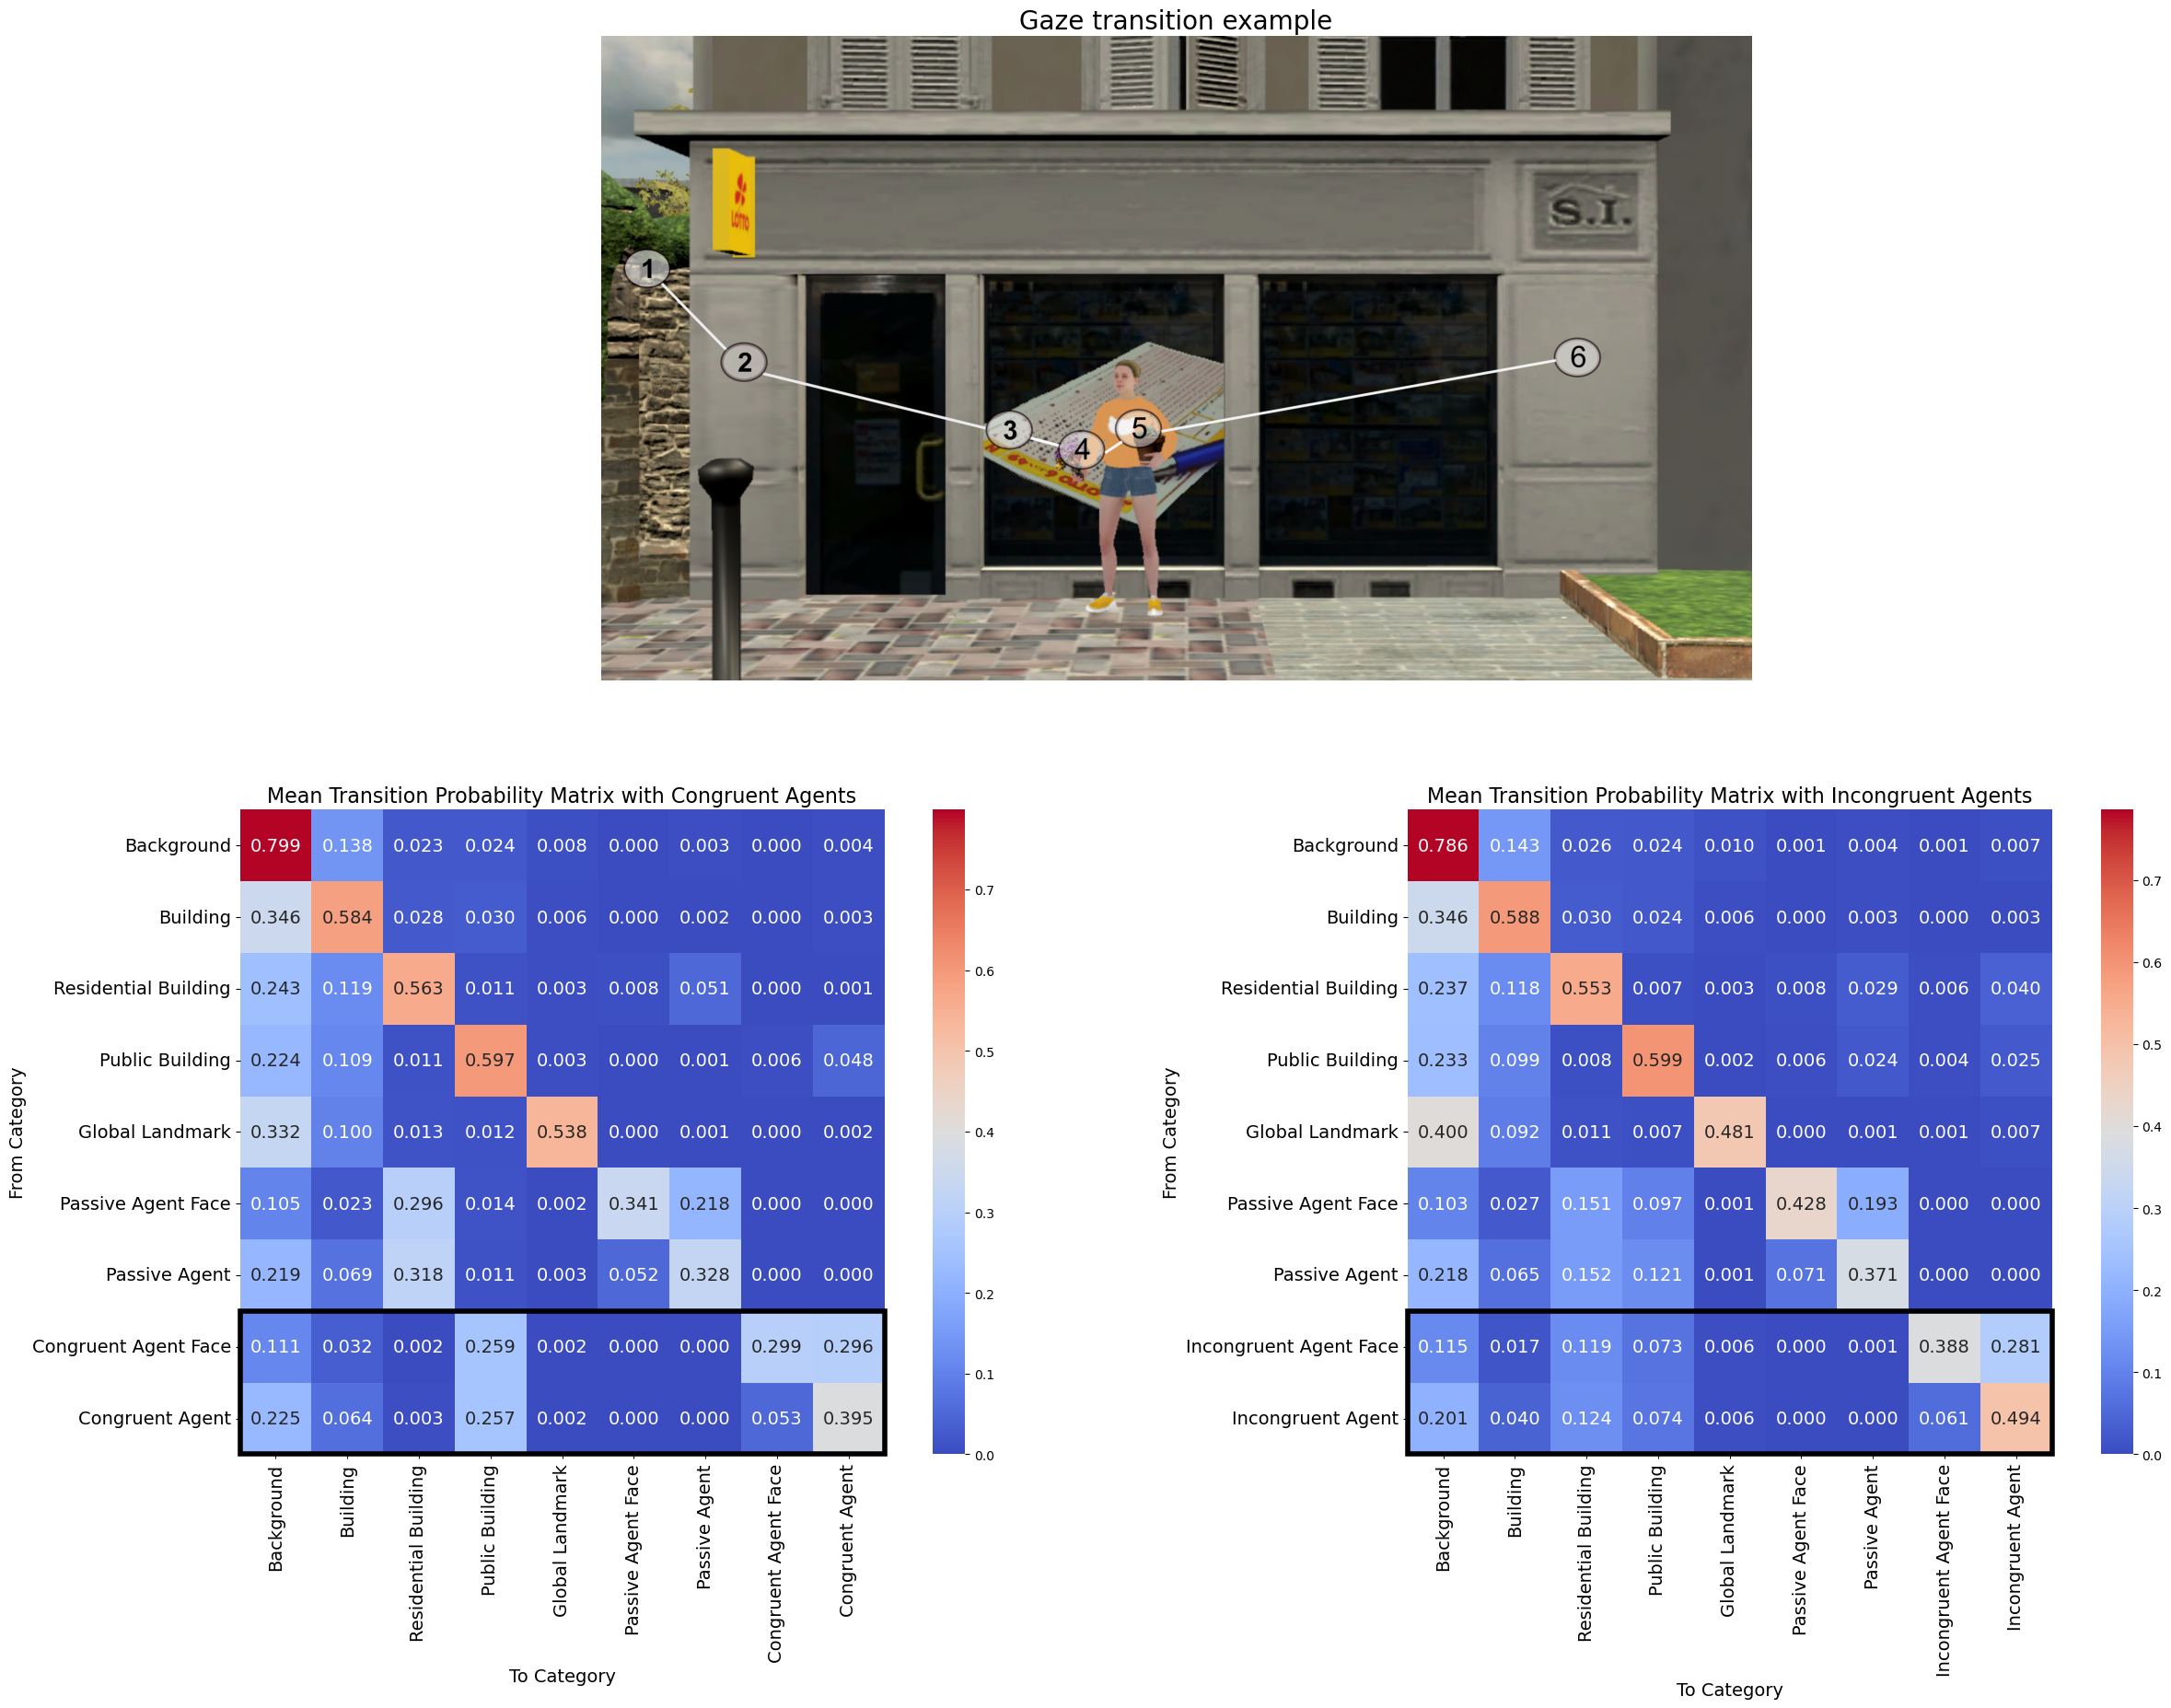

In [4]:


# Path to the screenshot
screenshot_path = "/Users/tracysanchezpacheco/Library/CloudStorage/OneDrive-Personal/PhD/Creation/Entropy_Gaze_transition.png" # Update this with your actual screenshot file path

# Load the screenshot
screenshot_img = mpimg.imread(screenshot_path)

# Create a grid layout with 2 rows: 1 for the screenshot, 1 for the heatmaps
fig = plt.figure(figsize=(30, 20))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1], hspace=0.2, wspace=0.2)

# Top row: Screenshot (spans both columns)
ax0 = fig.add_subplot(gs[0, :])  # Spans both columns
ax0.imshow(screenshot_img)
ax0.axis('off')  # Hide axes for the screenshot
ax0.set_title('Gaze transition example', fontsize=20)

# Bottom row, left: First heatmap
ax1 = fig.add_subplot(gs[1, 0])
sns.heatmap(general_matrix_exp1, annot=True, fmt=".3f", annot_kws={"size": 14},
            cmap="coolwarm", cbar=True, square=True,
            xticklabels=plot_labels_left, yticklabels=plot_labels_left, ax=ax1)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('Mean Transition Probability Matrix with Congruent Agents', fontsize=16)
ax1.set_xlabel('To Category', fontsize=14)
ax1.set_ylabel('From Category', fontsize=14)

# Add a rectangle to highlight the last two rows of the first heatmap
row_start = len(plot_labels_left) - 2
ax1.add_patch(plt.Rectangle(
    (0, row_start), len(plot_labels_left), 2,
    fill=False, edgecolor='black', linewidth=4, clip_on=False))

# Bottom row, right: Second heatmap
ax2 = fig.add_subplot(gs[1, 1])
sns.heatmap(general_matrix_exp2, annot=True, fmt=".3f", annot_kws={"size": 14},
            cmap="coolwarm", cbar=True, square=True,
            xticklabels=plot_labels_right, yticklabels=plot_labels_right, ax=ax2)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_title('Mean Transition Probability Matrix with Incongruent Agents', fontsize=16)
ax2.set_xlabel('To Category', fontsize=14)
ax2.set_ylabel('From Category', fontsize=14)

# Add a rectangle to highlight the last two rows of the second heatmap
ax2.add_patch(plt.Rectangle(
    (0, row_start), len(plot_labels_right), 2,
    fill=False, edgecolor='black', linewidth=4, clip_on=False))

# Save the figure
output_path = "/Volumes/TwoTeras/0_Experiment_1/Entropy_Results/mean_transition_matrices_screenshot_top.png"
plt.savefig(output_path, dpi=900, bbox_inches='tight')

# Show the plot
plt.show()


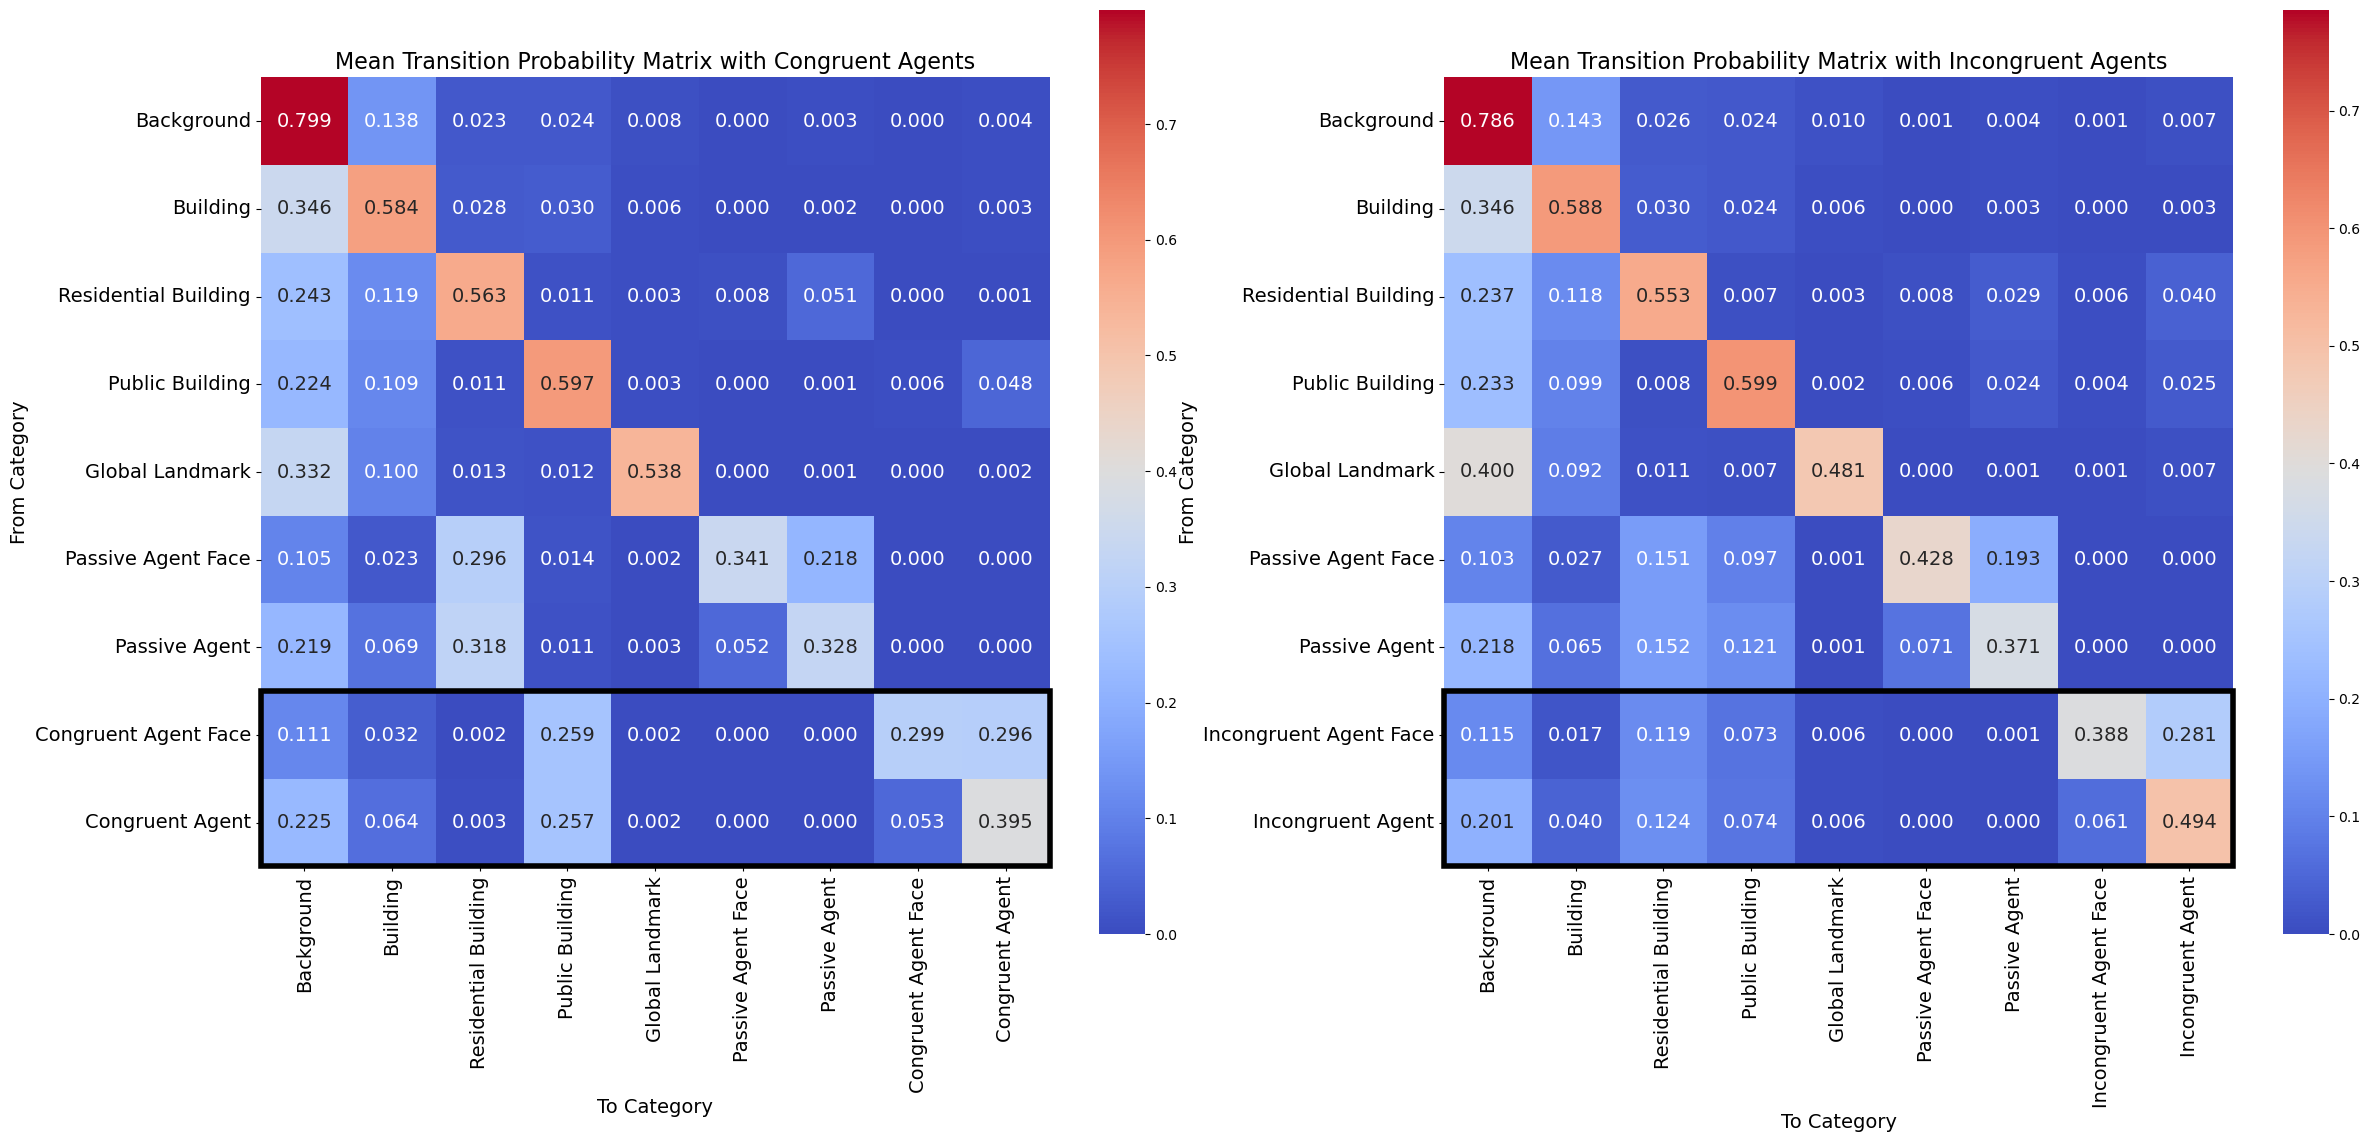

In [5]:

# Plot the heatmaps
fig, axes = plt.subplots(1, 2, figsize=(28, 12))

# Plot the first heatmap
sns.heatmap(general_matrix_exp1, annot=True, fmt=".3f", annot_kws={"size": 14},
            cmap="coolwarm", cbar=True, square=True,
            xticklabels=plot_labels_left, yticklabels=plot_labels_left, ax=axes[0])
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=14)
axes[0].set_title('Mean Transition Probability Matrix with Congruent Agents', fontsize=16)
axes[0].set_xlabel('To Category', fontsize=14)
axes[0].set_ylabel('From Category', fontsize=14)

# Add a rectangle to highlight the last two rows of the first heatmap
row_start = len(plot_labels_left) - 2
axes[0].add_patch(plt.Rectangle(
    (0, row_start), len(plot_labels_left), 2,
    fill=False, edgecolor='black', linewidth=4, clip_on=False))

# Plot the second heatmap
sns.heatmap(general_matrix_exp2, annot=True, fmt=".3f", annot_kws={"size": 14},
            cmap="coolwarm", cbar=True, square=True,
            xticklabels=plot_labels_right, yticklabels=plot_labels_right, ax=axes[1])
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=14)
axes[1].set_title('Mean Transition Probability Matrix with Incongruent Agents', fontsize=16)
axes[1].set_xlabel('To Category', fontsize=14)
axes[1].set_ylabel('From Category', fontsize=14)

# Add a rectangle to highlight the last two rows of the second heatmap
axes[1].add_patch(plt.Rectangle(
    (0, row_start), len(plot_labels_right), 2,
    fill=False, edgecolor='black', linewidth=4, clip_on=False))

# Save the figure
output_path = "/Volumes/TwoTeras/0_Experiment_1/Entropy_Results/mean_transition_matrices_paper.png"
plt.savefig(output_path, dpi=900, bbox_inches='tight')

# Show the plot
plt.show()


In [7]:
import os
import glob
import pandas as pd
import numpy as np
import re  # Import regex module

def validate_and_fix_transition_matrices(path, repair=False):
    """
    Validates transition matrices and optionally repairs them by:
    1. Identifying rows that do not sum to 1.
    2. Identifying negative values.
    3. (Optional) Replacing invalid rows with an equal probability distribution.

    Args:
    - path (str): Path to the directory containing transition matrix CSV files.
    - repair (bool): Whether to attempt fixing invalid rows.

    Returns:
    - invalid_matrices (dict): Dictionary of invalid matrices with details.
    """
    matrix_files = glob.glob(os.path.join(path, "*.csv"))
    if not matrix_files:
        print(f"No matrix files found in {path}")
        return {}

    invalid_matrices = {}

    for file in matrix_files:
        file_name = os.path.basename(file)

        # Skip files that do not start with digits
        if not re.match(r"^\d", file_name):
            print(f"Skipping file '{file_name}' as it does not start with digits.")
            continue

        print(f"Validating: {file}")
        df = pd.read_csv(file, index_col=0)  # Load the matrix

        # Check for rows that do not sum to 1
        row_sums = df.sum(axis=1)
        invalid_rows = row_sums[~np.isclose(row_sums, 1)].index
        if not invalid_rows.empty:
            print(f"Rows in {file} that do not sum to 1:")
            for idx in invalid_rows:
                print(f"  Row '{idx}': sum = {row_sums[idx]}")
            
            # Record invalid matrix details
            invalid_matrices[file] = {
                'invalid_rows': {idx: row_sums[idx] for idx in invalid_rows}
            }

            # Optionally repair invalid rows
            if repair:
                for idx in invalid_rows:
                    if df.loc[idx].sum() == 0:
                        # Replace row with equal probabilities if it's all zeros
                        df.loc[idx] = 1 / len(df.columns)
                    else:
                        # Normalize rows that are slightly off
                        df.loc[idx] = df.loc[idx] / df.loc[idx].sum()

        # Check for negative values
        has_negative = (df < 0).any().any()
        if has_negative:
            print(f"Negative values found in {file}:")
            print(df[df < 0])
            invalid_matrices[file]['negative_values'] = df[df < 0].to_dict()

        # Save the repaired matrix if repairs were made
        if repair and file in invalid_matrices:
            repaired_path = file.replace(".csv", "_repaired.csv")
            df.to_csv(repaired_path)
            print(f"Repaired matrix saved to: {repaired_path}")

        print(f"Matrix {file} validation complete.\n")

    return invalid_matrices

# Example usage
path = "/Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/"
invalid_matrices = validate_and_fix_transition_matrices(path, repair=True)

# Log invalid matrices for further inspection
if invalid_matrices:
    invalid_log_path = os.path.join(path, "invalid_matrices_log_merged.csv")
    pd.DataFrame.from_dict(invalid_matrices, orient='index').to_csv(invalid_log_path)
    print(f"Invalid matrices logged to: {invalid_log_path}")
else:
    print("All matrices passed validation.")


Validating: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1031_1_transition_matrix.csv
Rows in /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1031_1_transition_matrix.csv that do not sum to 1:
  Row 'Background': sum = 3591.0
  Row 'Building': sum = 1333.0
  Row 'TaskBuilding_Public': sum = 466.0
  Row 'TaskBuilding_Residential': sum = 310.0
  Row 'Global_Landmark': sum = 127.0
  Row 'Passive_Agent_Face': sum = 15.0
  Row 'Passive_Agent': sum = 36.0
  Row 'Active_Agent_Face': sum = 31.0
  Row 'Active_Agent': sum = 77.0
Repaired matrix saved to: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1031_1_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1031_1_transition_matrix.csv validation complete.

Validating: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1031_2_transition_matrix.csv
Rows in /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1031_2_transition_matrix.csv that do not sum to 1

Repaired matrix saved to: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1574_3_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1574_3_transition_matrix.csv validation complete.

Validating: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1574_4_transition_matrix.csv
Rows in /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1574_4_transition_matrix.csv that do not sum to 1:
  Row 'Background': sum = 3360.0
  Row 'Building': sum = 1732.0
  Row 'TaskBuilding_Public': sum = 576.0
  Row 'TaskBuilding_Residential': sum = 371.0
  Row 'Global_Landmark': sum = 9.0
  Row 'Passive_Agent_Face': sum = 7.0
  Row 'Passive_Agent': sum = 28.0
  Row 'Active_Agent_Face': sum = 2.0
  Row 'Active_Agent': sum = 47.0
Repaired matrix saved to: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1574_4_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1574_4_transition_matrix.csv va

Repaired matrix saved to: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/3193_1_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/3193_1_transition_matrix.csv validation complete.

Validating: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/3193_2_transition_matrix.csv
Rows in /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/3193_2_transition_matrix.csv that do not sum to 1:
  Row 'Background': sum = 3188.0
  Row 'Building': sum = 1336.0
  Row 'TaskBuilding_Public': sum = 308.0
  Row 'TaskBuilding_Residential': sum = 500.0
  Row 'Global_Landmark': sum = 140.0
  Row 'Passive_Agent_Face': sum = 80.0
  Row 'Passive_Agent': sum = 139.0
  Row 'Active_Agent_Face': sum = 41.0
  Row 'Active_Agent': sum = 155.0
Repaired matrix saved to: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/3193_2_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/3193_2_transition_matrix.

Repaired matrix saved to: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/4598_3_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/4598_3_transition_matrix.csv validation complete.

Validating: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/4598_4_transition_matrix.csv
Rows in /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/4598_4_transition_matrix.csv that do not sum to 1:
  Row 'Background': sum = 3649.0
  Row 'Building': sum = 900.0
  Row 'TaskBuilding_Public': sum = 262.0
  Row 'TaskBuilding_Residential': sum = 384.0
  Row 'Global_Landmark': sum = 49.0
  Row 'Passive_Agent_Face': sum = 22.0
  Row 'Passive_Agent': sum = 177.0
  Row 'Active_Agent_Face': sum = 31.0
  Row 'Active_Agent': sum = 277.0
Repaired matrix saved to: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/4598_4_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/4598_4_transition_matrix.cs

Rows in /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/5161_3_transition_matrix.csv that do not sum to 1:
  Row 'Background': sum = 3367.0
  Row 'Building': sum = 1101.0
  Row 'TaskBuilding_Public': sum = 270.0
  Row 'TaskBuilding_Residential': sum = 497.0
  Row 'Global_Landmark': sum = 116.0
  Row 'Passive_Agent_Face': sum = 32.0
  Row 'Passive_Agent': sum = 162.0
  Row 'Active_Agent_Face': sum = 14.0
  Row 'Active_Agent': sum = 207.0
Repaired matrix saved to: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/5161_3_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/5161_3_transition_matrix.csv validation complete.

Validating: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/5161_4_transition_matrix.csv
Rows in /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/5161_4_transition_matrix.csv that do not sum to 1:
  Row 'Background': sum = 3468.0
  Row 'Building': sum = 1372.0
  Row 'TaskBuilding_Public': su

Rows in /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/5851_1_transition_matrix.csv that do not sum to 1:
  Row 'Background': sum = 4120.0
  Row 'Building': sum = 1416.0
  Row 'TaskBuilding_Public': sum = 285.0
  Row 'TaskBuilding_Residential': sum = 224.0
  Row 'Global_Landmark': sum = 152.0
  Row 'Passive_Agent_Face': sum = 3.0
  Row 'Passive_Agent': sum = 27.0
  Row 'Active_Agent_Face': sum = 2.0
  Row 'Active_Agent': sum = 26.0
Repaired matrix saved to: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/5851_1_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/5851_1_transition_matrix.csv validation complete.

Validating: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/5851_2_transition_matrix.csv
Rows in /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/5851_2_transition_matrix.csv that do not sum to 1:
  Row 'Background': sum = 3718.0
  Row 'Building': sum = 1236.0
  Row 'TaskBuilding_Public': sum = 

Repaired matrix saved to: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/7081_3_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/7081_3_transition_matrix.csv validation complete.

Validating: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/7081_4_transition_matrix.csv
Rows in /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/7081_4_transition_matrix.csv that do not sum to 1:
  Row 'Background': sum = 3011.0
  Row 'Building': sum = 1966.0
  Row 'TaskBuilding_Public': sum = 195.0
  Row 'TaskBuilding_Residential': sum = 322.0
  Row 'Global_Landmark': sum = 47.0
  Row 'Passive_Agent_Face': sum = 2.0
  Row 'Passive_Agent': sum = 10.0
  Row 'Active_Agent_Face': sum = 0.0
  Row 'Active_Agent': sum = 5.0
Repaired matrix saved to: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/7081_4_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/7081_4_transition_matrix.csv va

Repaired matrix saved to: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/8629_2_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/8629_2_transition_matrix.csv validation complete.

Validating: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/8629_3_transition_matrix.csv
Rows in /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/8629_3_transition_matrix.csv that do not sum to 1:
  Row 'Background': sum = 3222.0
  Row 'Building': sum = 977.0
  Row 'TaskBuilding_Public': sum = 263.0
  Row 'TaskBuilding_Residential': sum = 374.0
  Row 'Global_Landmark': sum = 110.0
  Row 'Passive_Agent_Face': sum = 156.0
  Row 'Passive_Agent': sum = 152.0
  Row 'Active_Agent_Face': sum = 106.0
  Row 'Active_Agent': sum = 291.0
Repaired matrix saved to: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/8629_3_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/8629_3_transition_matrix

Repaired matrix saved to: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1234_2_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1234_2_transition_matrix.csv validation complete.

Validating: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1234_3_transition_matrix.csv
Rows in /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1234_3_transition_matrix.csv that do not sum to 1:
  Row 'Background': sum = 1564.0
  Row 'Building': sum = 647.0
  Row 'TaskBuilding_Public': sum = 89.0
  Row 'TaskBuilding_Residential': sum = 121.0
  Row 'Global_Landmark': sum = 100.0
  Row 'Passive_Agent': sum = 6.0
  Row 'Active_Agent_Face': sum = 2.0
  Row 'Active_Agent': sum = 7.0
Repaired matrix saved to: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1234_3_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1234_3_transition_matrix.csv validation complete.

Validating: /Volumes

Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1843_3_transition_matrix_repaired.csv validation complete.

Validating: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1843_4_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1843_4_transition_matrix_repaired.csv validation complete.

Validating: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1843_5_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/1843_5_transition_matrix_repaired.csv validation complete.

Validating: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/2069_1_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/2069_1_transition_matrix_repaired.csv validation complete.

Validating: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/2069_2_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/206

Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/5189_1_transition_matrix_repaired.csv validation complete.

Validating: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/5189_2_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/5189_2_transition_matrix_repaired.csv validation complete.

Validating: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/5189_3_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/5189_3_transition_matrix_repaired.csv validation complete.

Validating: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/5189_4_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/5189_4_transition_matrix_repaired.csv validation complete.

Validating: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/5189_5_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/518

Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/7935_1_transition_matrix_repaired.csv validation complete.

Validating: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/7935_2_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/7935_2_transition_matrix_repaired.csv validation complete.

Validating: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/7935_3_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/7935_3_transition_matrix_repaired.csv validation complete.

Validating: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/7935_4_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/7935_4_transition_matrix_repaired.csv validation complete.

Validating: /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/7935_5_transition_matrix_repaired.csv
Matrix /Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/793

In [ ]:


def calculate_mean_matrix(path, reference_index=None):
    # Load all transition matrix CSV files in the directory
    matrix_files = glob.glob(os.path.join(path, "*.csv"))

    if not matrix_files:
        print(f"No matrix files found in {path}")
        return None

    normalized_matrices = []

    for i, file in enumerate(matrix_files):
        df = pd.read_csv(file, index_col=0)

        if reference_index is None and i == 0:
            reference_index = df.index

        df = df.reindex(index=reference_index, columns=reference_index).fillna(0)

        row_sums = df.sum(axis=1)
        df = df.div(row_sums.replace(0, 1), axis=0).fillna(0)  # Handle zero-sum rows

        if not df.sum(axis=1).all():
            print(f"Warning: Non-normalized row detected in {file}")
        
        normalized_matrices.append(df)

    # Calculate mean matrix
    mean_matrix = sum(normalized_matrices) / len(normalized_matrices)

    return mean_matrix

# Replace underscores and adjust "TaskBuilding" and remove "Agent" in tick labels
def adjust_label(label):
    label = label.replace("_", " ")
    if "TaskBuilding" in label:
        label = label.replace("TaskBuilding", "") + " Building"  # Add " Building" if "TaskBuilding" was removed
    if "Active" in label:
        label = label.replace("Active", "Congruent")  # Replace "Active" with "Congruent"
    return label.strip()  # Remove any extra spaces

# Paths for each experiment
path_exp1 = "/Volumes/TwoTeras/0_Experiment_1/Entropy_Results/Matrices/"
path_exp2 = "/Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices/"

# Calculate mean matrices for each experiment
mean_matrix_exp1 = calculate_mean_matrix(path_exp1)
mean_matrix_exp2 = calculate_mean_matrix(path_exp2, reference_index=mean_matrix_exp1.index)

# Desired order of categories for the heatmaps
original_order = [
    "Background", "Building", "TaskBuilding_Residential", "TaskBuilding_Public",
    "Global_Landmark", "Passive_Agent",  "Active_Agent"
]

# Reindex matrices using the original labels
mean_matrix_exp1 = mean_matrix_exp1.reindex(index=original_order, columns=original_order).fillna(0)
mean_matrix_exp2 = mean_matrix_exp2.reindex(index=original_order, columns=original_order).fillna(0)

# Apply adjust_label to the labels for plotting only
plot_labels_left = [adjust_label(label) for label in original_order]
plot_labels_right = [adjust_label(label.replace("Congruent", "Incongruent")) for label in plot_labels_left]

# Plot the heatmaps
fig, axes = plt.subplots(1, 2, figsize=(28, 12))

# Plot the first heatmap
sns.heatmap(mean_matrix_exp1, annot=True, fmt=".2f", annot_kws={"size": 14},
            cmap="coolwarm", cbar=True, square=True,
            xticklabels=plot_labels_left, yticklabels=plot_labels_left, ax=axes[0])
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=14)
axes[0].set_title('Mean Transition Probability Matrix with Congruent Agents', fontsize=16)
axes[0].set_xlabel('To Category', fontsize=14)
axes[0].set_ylabel('From Category', fontsize=14)

# Add a rectangle to highlight the last two rows of the first heatmap
row_start = len(plot_labels_left) - 2  # Index of the second-to-last row
axes[0].add_patch(plt.Rectangle(
    (0, row_start), len(plot_labels_left), 2,  # Align rectangle to gridlines
    fill=False, edgecolor='black', linewidth=4, clip_on=False))

# Plot the second heatmap
sns.heatmap(mean_matrix_exp2, annot=True, fmt=".2f", annot_kws={"size": 14},
            cmap="coolwarm", cbar=True, square=True,
            xticklabels=plot_labels_right, yticklabels=plot_labels_right, ax=axes[1])
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=14)
axes[1].set_title('Mean Transition Probability Matrix with Incongruent Agents', fontsize=16)
axes[1].set_xlabel('To Category', fontsize=14)
axes[1].set_ylabel('From Category', fontsize=14)

# Add a rectangle to highlight the last two rows of the second heatmap
axes[1].add_patch(plt.Rectangle(
    (0, row_start), len(plot_labels_right), 2,  # Align rectangle to gridlines
    fill=False, edgecolor='black', linewidth=4, clip_on=False))

# Save the figure
output_path = "/Volumes/TwoTeras/0_Experiment_1/Entropy_Results/mean_transition_matrices_paper.png"  # Replace with your desired file path
plt.savefig(output_path, dpi=900, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
# Print the original row/column names for organization
original_ticks_exp1 = list(mean_matrix_exp1.index)
original_ticks_exp2 = list(mean_matrix_exp2.index)

print("Original Categories (Experiment 1):", original_ticks_exp1)
print("Original Categories (Experiment 2):", original_ticks_exp2)


In [ ]:


# Main function to calculate the mean matrix
def calculate_mean_matrix(path, reference_index=None):
    # Load all transition matrix CSV files in the directory
    matrix_files = glob.glob(os.path.join(path, "*_1_transition_matrix.csv"))

    # Initialize a list to store each matrix as a DataFrame
    matrices = []

    # Load each matrix and append it to the list
    for i, file in enumerate(matrix_files):
        df = pd.read_csv(file, index_col=0)  # Assuming the first column is the row index

        # Set reference index based on the first matrix encountered, if not specified
        if reference_index is None:
            reference_index = df.index

        # Reindex to ensure consistent category order
        df = df.reindex(index=reference_index, columns=reference_index).fillna(0)

        matrices.append(df)

    # Calculate the mean of all matrices without normalization
    mean_matrix = sum(matrices) / len(matrices)
    
    return mean_matrix

# Paths for each experiment
path_exp1 = "/Volumes/TwoTeras/0_Experiment_1/Entropy_Results/Matrices"
path_exp2 = "/Volumes/TwoTeras/1_Experiment_2/Entropy_Results/Matrices"

# Calculate mean matrices for each experiment, using a fixed category order based on Experiment 1
mean_matrix_exp1 = calculate_mean_matrix(path_exp1)
mean_matrix_exp2 = calculate_mean_matrix(path_exp2, reference_index=mean_matrix_exp1.index)

# Plot the mean matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(25, 12))

sns.heatmap(mean_matrix_exp1, annot=True, cmap="YlGnBu", cbar=True, square=True,
            xticklabels=mean_matrix_exp1.columns, yticklabels=mean_matrix_exp1.index, ax=axes[0])
axes[0].set_title('Mean Transition Probability Matrix - Experiment 1 (First Session Only)')
axes[0].set_xlabel('To Category')
axes[0].set_ylabel('From Category')

sns.heatmap(mean_matrix_exp2, annot=True, cmap="YlGnBu", cbar=True, square=True,
            xticklabels=mean_matrix_exp2.columns, yticklabels=mean_matrix_exp2.index, ax=axes[1])
axes[1].set_title('Mean Transition Probability Matrix - Experiment 2 (First Session Only)')
axes[1].set_xlabel('To Category')
axes[1].set_ylabel('From Category')

# Save the figure
output_path = "/Volumes/TwoTeras/0_Experiment_1/Entropy_Results/mean_transition_matrices.png"  # Replace with your desired file path
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()
